<a href="https://colab.research.google.com/github/naderghanbari/mcgill-capstone/blob/master/mcgill_capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import libraries

In [ ]:
!pip install geopandas

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

# Data collection

In [ ]:
# Collect Montreal firefighter interventions from 2015 to date
%%bash
mkdir -p interventions
curl http://donnees.ville.montreal.qc.ca/dataset/701683f0-a838-4fe0-b4d6-a4964d9ea7f0/resource/9e67d2f3-9104-4af4-aac4-022df621a749/download/donneesouvertes-interventions-sim.csv --silent --output interventions/interventions.csv
echo Number of lines: `wc -l interventions/*`

Number of lines: 641828 interventions/interventions.csv


In [ ]:
# Collect Montreal fire stations dataset
%%bash
mkdir -p stations
curl http://donnees.ville.montreal.qc.ca/dataset/c69e78c6-e454-4bd9-9778-e4b0eaf8105b/resource/f6542ad1-31f5-458e-b33d-1a028fab3e98/download/casernes.csv --silent --output stations/stations.csv
echo Number of lines: `wc -l stations/*`

Number of lines: 69 stations/stations.csv


In [ ]:
# Collect Montreal fire station divisions dataset
%%bash
mkdir -p divisions
curl https://storage.googleapis.com/capstone-data-lake/divisions/divisions.csv --silent --output divisions/divisions.csv
echo Number of lines: `wc -l divisions/*`

Number of lines: 68 divisions/divisions.csv


In [ ]:
# Collect Montreal crime data from 2015 to date
%%bash
mkdir -p crimes
curl http://donnees.ville.montreal.qc.ca/dataset/5829b5b0-ea6f-476f-be94-bc2b8797769a/resource/c6f482bf-bf0f-4960-8b2f-9982c211addd/download/interventionscitoyendo.csv --silent --output crimes/crimes.csv
echo Number of lines: `wc -l crimes/*`

Number of lines: 171443 crimes/crimes.csv


In [ ]:
# Collect Montreal hourly weather data from 2015 to 2019
%%bash
FROM=2015
TO=2019
STATION=30165
mkdir -p weather
for year in $(seq $FROM $TO); do
  for month in {01..12}; do
    curl https://climate.weather.gc.ca/climate_data/bulk_data_e.html\?format\=csv\&stationID\=$STATION\&Year\=$year\&Month\=$month\&Day\=1\&timeframe\=1\&submit\=Download+Data --silent --output weather/$year-$month.csv &
  done;
done

In [ ]:
# Count check
assert(len(os.listdir("weather")) == 60)

# Data ingestion, merging, and cleaning
First we load the stations and divisions datasets.

In [ ]:
# Read stations to a Pandas dataframe and keep only relevant columns
stations = pd.read_csv("stations/stations.csv", dtype={"CASERNE":"string"})
stations.rename(columns={"CASERNE":"station", "LATITUDE":"latitude", "LONGITUDE": "longitude"}, inplace=True)
stations = stations[["station","latitude","longitude"]]
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude))
stations.head()

,station,latitude,longitude,geometry
0,03,45.493454,-73.560172,POINT (-73.56017 45.49345)
1,15,45.484419,-73.560917,POINT (-73.56092 45.48442)
2,23,45.477925,-73.585251,POINT (-73.58525 45.47793)
3,33,45.457841,-73.595450,POINT (-73.59545 45.45784)
4,09,45.563748,-73.610169,POINT (-73.61017 45.56375)


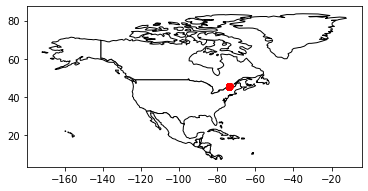

In [ ]:
# Visual check for latitude and longitude
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = world[world.continent == "North America"].plot(color="white",edgecolor="black")
stations.plot(ax=ax,color='red');

In [ ]:
# Read divisions to a Pandas dataframe
divisions = pd.read_csv("divisions/divisions.csv", dtype={"station":"string", "division":"string"})
divisions.head()

,station,division
0,51,1
1,52,1
2,53,1
3,54,1
4,55,1


In the next step we merge the stations dataframe with divisions. This will automatically filter out the only decommissioned station, so there is no 
need to manually remove it from the dataset.

In [ ]:
# Merge stations with divisions
stations = stations.join(divisions.set_index("station"), on="station", how="inner")
stations.head()

,station,latitude,longitude,geometry,division
1,15,45.484419,-73.560917,POINT (-73.56092 45.48442),2
2,23,45.477925,-73.585251,POINT (-73.58525 45.47793),2
3,33,45.457841,-73.595450,POINT (-73.59545 45.45784),2
5,37,45.546373,-73.626758,POINT (-73.62676 45.54637),3
6,41,45.527630,-73.626383,POINT (-73.62638 45.52763),5


Now we load the interventions dataset, which is our main dataset.

In [ ]:
interventions = pd.read_csv(  
  "interventions/interventions.csv", 
  usecols=["CREATION_DATE_TIME","CASERNE","DIVISION","NOMBRE_UNITES"], 
  dtype={
    "CASERNE": "string",
    "DIVISION": "string",
    "NOMBRE_UNITES": pd.Int64Dtype()
  },
  parse_dates=["CREATION_DATE_TIME"]
)
interventions["NOMBRE_UNITES"] = interventions["NOMBRE_UNITES"].fillna(0).astype(int)
interventions.rename(
  columns={
    "CREATION_DATE_TIME": "incident_time",
    "CASERNE": "station", 
    "DIVISION": "target_division",
    "NOMBRE_UNITES": "units_deployed"
  }, 
  inplace=True
)

interventions.head()

,incident_time,station,target_division,units_deployed
0,2015-08-10 17:53:07,29,7,1
1,2015-08-12 03:26:56,38,9,1
2,2015-08-12 23:38:30,40,7,1
3,2015-08-13 20:45:33,30,7,1
4,2015-08-01 04:53:57,72,3,1


Now we merge interventions with divisions so for each incident we know
exactly which division responded to the call.

In [ ]:
# Merge interventions with divisions
interventions = interventions.join(divisions.set_index("station"), on="station", how="inner")
interventions.head()

,incident_time,station,target_division,units_deployed,division
0,2015-08-10 17:53:07,29,7,1,5
30,2015-09-07 12:23:40,29,7,7,5
80,2015-08-25 19:03:42,29,7,2,5
157,2015-01-27 11:00:51,29,7,37,5
219,2015-02-23 23:48:24,29,7,1,5


In [60]:
# Read crimes dataset into a Pandas dataframe
crimes = pd.read_csv("crimes/crimes.csv", encoding="ISO-8859-1")
crimes.rename(columns={"DATE":"date", "LATITUDE":"latitude", "LONGITUDE":"longitude"}, inplace=True)
crimes = crimes[["date","latitude","longitude"]]
crimes.head()

,date,latitude,longitude
0,2018-09-13,45.567780,-73.626778
1,2018-04-30,45.567780,-73.626778
2,2018-09-01,45.519122,-73.685928
3,2017-07-21,1.000000,1.000000
4,2017-07-29,1.000000,1.000000


In [61]:
# Cleanup by removing bad latitude and longitudes
crimes_good_latitudes = crimes["latitude"].between(45.3583897,45.7735297)
crimes_good_longitudes = crimes["longitude"].between(-74.1045037,-73.365220)

crimes = crimes[crimes_good_latitudes & crimes_good_longitudes]
crimes = gpd.GeoDataFrame(crimes, geometry=gpd.points_from_xy(crimes.longitude, crimes.latitude))
crimes.head()

,date,latitude,longitude,geometry
0,2018-09-13,45.567780,-73.626778,POINT (-73.62678 45.56778)
1,2018-04-30,45.567780,-73.626778,POINT (-73.62678 45.56778)
2,2018-09-01,45.519122,-73.685928,POINT (-73.68593 45.51912)
6,2017-07-30,45.516776,-73.591457,POINT (-73.59146 45.51678)
8,2017-08-01,45.602873,-73.635117,POINT (-73.63512 45.60287)


# Aggregation
At this step we aggregate the data to prepare it in its final shape
ebfore a final round of merging and prepreocessing.

In [ ]:
# Exctract the date as a new column
interventions["incident_date"] = interventions["incident_time"].dt.date
interventions["incidents"] = 1
interventions.head()

,incident_time,station,target_division,units_deployed,division,incident_date,incidents
0,2015-08-10 17:53:07,29,7,1,5,2015-08-10,1
30,2015-09-07 12:23:40,29,7,7,5,2015-09-07,1
80,2015-08-25 19:03:42,29,7,2,5,2015-08-25,1
157,2015-01-27 11:00:51,29,7,37,5,2015-01-27,1
219,2015-02-23 23:48:24,29,7,1,5,2015-02-23,1


In [ ]:
# Aggregate number of incidents and units deployed per date/division
# SELECT incident_date, division, SUM(units_deployed), COUNT(incidents) FROM interventions GROUP BY incident_date, division

incidents_date_division = interventions[["incident_date","division","incidents","units_deployed"]].groupby(["incident_date", "division"]).sum()
incidents_date_division.head()

incidents  units_deployed
incident_date division                           
2015-01-01    1                34              59
              2                81             140
              3                70             118
              4                70              92
              5                84             137

In [ ]:
# Aggregate number of incidents and units deployed per date/target_division

incidents_date_target_division = interventions[["incident_date","target_division","incidents","units_deployed"]].groupby(["incident_date", "target_division"]).sum()
incidents_date_target_division.head()

incidents  units_deployed
incident_date target_division                           
2015-01-01    0                        1               4
              1                       22              39
              10                      67              92
              11                      47              72
              12                      36              65